In [1]:
!pip -q install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Spark DataFrame").getOrCreate()
print("Spark session started")

Spark session started


In [3]:
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
df = spark.read.csv(filename, header=True, inferSchema=True)
print("CSV file loaded into DataFrame")

Saving flights_2000.csv to flights_2000.csv
CSV file loaded into DataFrame


**Βήμα 1ο**

In [4]:
clean_df = df.filter(F.col("CANCELLED") == 0).na.drop(subset=["DEP_DELAY"])
df_with_hour = df.withColumn("HOUR", (F.col("SCHED_DEP").substr(12,2)).cast("int"))

hours_delay = df_with_hour.groupBy("HOUR").agg(F.avg("DEP_DELAY").alias("AVG_DELAY")).orderBy("HOUR")
#hours_delay.show(24)

**Γράφημα α)**

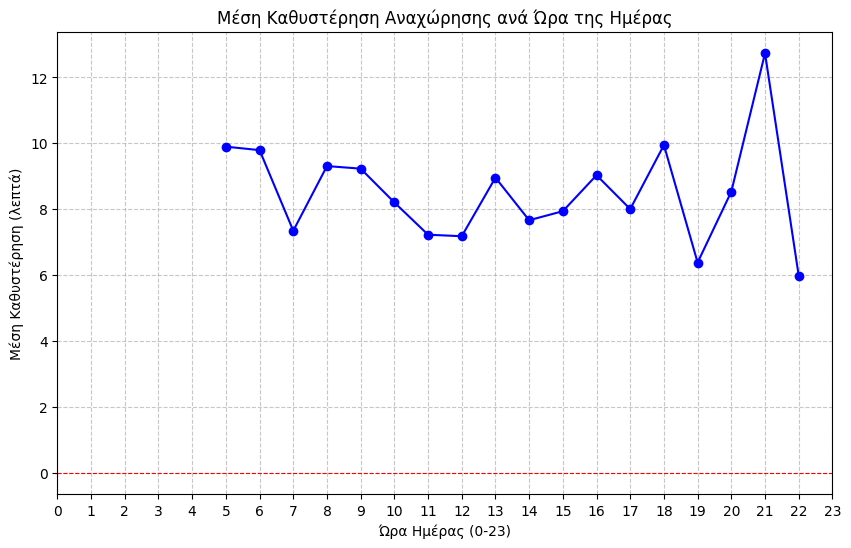

In [5]:
# Μετατροπή σε Pandas για να φτιάξουμε το γράφημα
pd_hours = hours_delay.toPandas()

# Δημιουργία Γραφήματος (Line Plot)
plt.figure(figsize=(10, 6))

# X άξονας: Ώρα, Y άξονας: Μέση Καθυστέρηση
# Χρησιμοποιούμε marker='o' για να φαίνονται οι τελείες σε κάθε ώρα
plt.plot(pd_hours['HOUR'], pd_hours['AVG_DELAY'], marker='o', linestyle='-', color='b')

plt.title('Μέση Καθυστέρηση Αναχώρησης ανά Ώρα της Ημέρας')
plt.xlabel('Ώρα Ημέρας (0-23)')
plt.ylabel('Μέση Καθυστέρηση (λεπτά)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 24)) # Για να δείχνει όλες τις ώρες στον άξονα Χ

# Προσθήκη οριζόντιας κόκκινης γραμμής στο 0 (για να ξεχωρίζουν οι πρόωρες αφίξεις)
plt.axhline(0, color='red', linewidth=0.8, linestyle='--')

plt.show()

**Γράφημα β)**

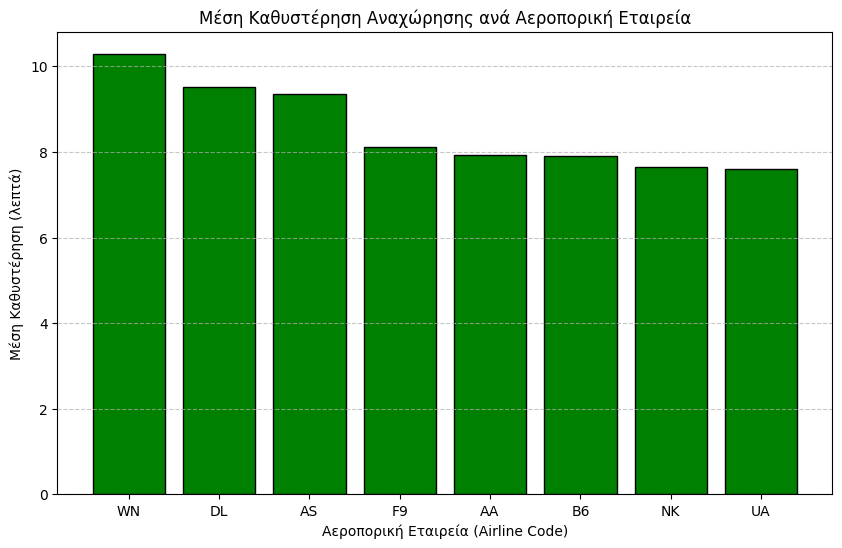

In [6]:
airline_delays = clean_df.groupBy("AIRLINE").agg(F.avg("DEP_DELAY").alias("AVG_DELAY")).orderBy("AVG_DELAY", ascending=False)
#Convert to Pandas
pd_airline = airline_delays.toPandas()

#Plot
plt.figure(figsize=(10,6))
plt.bar(pd_airline['AIRLINE'], pd_airline['AVG_DELAY'], color='green', edgecolor='black')

plt.title('Μέση Καθυστέρηση Αναχώρησης ανά Αεροπορική Εταιρεία')
plt.xlabel('Αεροπορική Εταιρεία (Airline Code)')
plt.ylabel('Μέση Καθυστέρηση (λεπτά)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Γράφημα γ)**

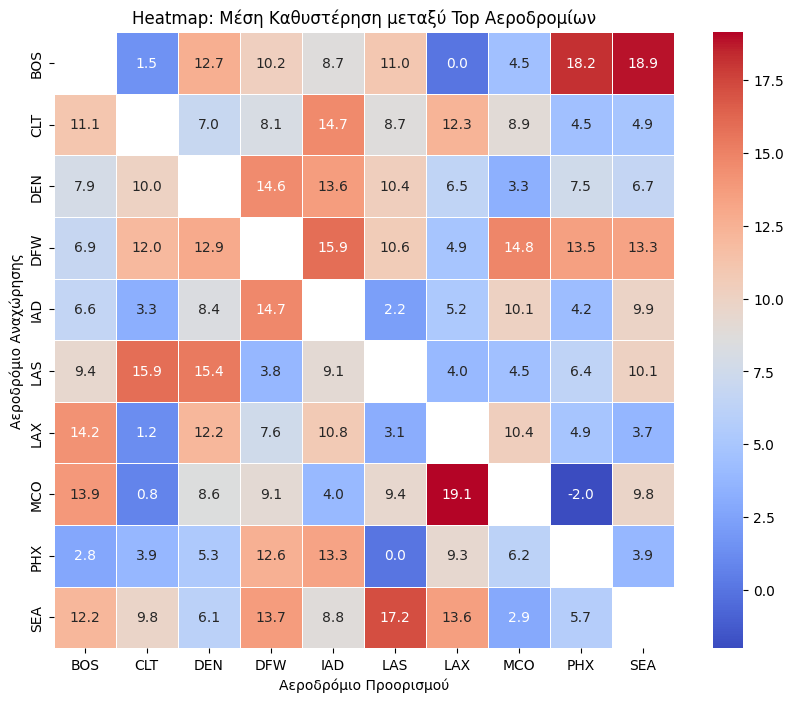

In [7]:
# 1. Βρίσκουμε τα top-10 αεροδρόμια (βάσει κίνησης) για να φτιάξουμε ένα καθαρό γράφημα
top_airports_rows = df.groupBy("ORIGIN_AIRPORT").count().orderBy(F.col("count").desc()).limit(10).collect()
top_airports_list = [row["ORIGIN_AIRPORT"] for row in top_airports_rows]

# 2. Φιλτράρουμε τα δεδομένα ώστε να κρατήσουμε πτήσεις ΜΟΝΟ μεταξύ αυτών των top αεροδρομίων
df_heatmap_data = clean_df.filter(
    (F.col("ORIGIN_AIRPORT").isin(top_airports_list)) &
    (F.col("DEST_AIRPORT").isin(top_airports_list)))

# 3. Ομαδοποίηση: Origin, Dest -> Avg Delay
heatmap_spark = df_heatmap_data.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT").agg(F.avg("DEP_DELAY").alias("avg_delay"))

# --- Οπτικοποίηση (Seaborn) ---

# Μετατροπή σε Pandas
pdf_heatmap = heatmap_spark.toPandas()

# Μετατροπή των δεδομένων σε μορφή πίνακα (Matrix) για το Heatmap
# Index: Origin, Columns: Destination, Values: Avg Delay
matrix_df = pdf_heatmap.pivot(index='ORIGIN_AIRPORT', columns='DEST_AIRPORT', values='avg_delay')

plt.figure(figsize=(10, 8))

# Σχεδίαση Heatmap
# cmap='coolwarm': Μπλε για μικρές/αρνητικές καθυστερήσεις, Κόκκινο για μεγάλες
# annot=True: Εμφανίζει τα νούμερα μέσα στα κουτάκια
sns.heatmap(matrix_df, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5)

plt.title('Heatmap: Μέση Καθυστέρηση μεταξύ Top Αεροδρομίων')
plt.xlabel('Αεροδρόμιο Προορισμού')
plt.ylabel('Αεροδρόμιο Αναχώρησης')

plt.show()